### Import Needed library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import psycopg2
import matplotlib.pyplot as plt
import scipy.stats
from prettytable import PrettyTable
import math

### Loading Data...

In [2]:
postgresConnection = psycopg2.connect(host='***', port='5432', database='***', user='***', password='***')
cursor = postgresConnection.cursor()
data = pd.read_sql('select * from Course2_ToolTechniquesforDataScience',postgresConnection)
cursor.close()

### Looking at data
  To take a first look at the data we can use different commands, here are some of the popular one

In [3]:
print('look to data\n')
print(data.head())
print('\nDescribe the integer features\n')
print(data.describe())
print('\ncheck current situation of all features\n')
print(data.info())

look to data

  serial_number payment_type province_name  gender  age nationality  \
0      C0000032          PRE       esfahan    male   77          FI   
1      C0000071          PRE       esfahan    male   37          US   
2      C0000101          PRE       esfahan    male   41          IE   
3      C0000212          PRE       esfahan  female   35          IE   
4      C0000239          PRE       esfahan  female   29          FI   

     payment       sms     data  data_package       voice  
0   700000.0    125.54     0.00     3619890.0    5340.391  
1        0.0   9917.66     0.00       35490.4    1143.204  
2   670000.0   1129.86     0.00     5581236.0   63496.758  
3    50000.0   1632.02  7779.33        7673.6   53452.902  
4  1680000.0  47912.32     0.00     3723483.5  268440.380  

Describe the integer features

                age       payment           sms          data  data_package  \
count  2.546549e+06  2.546549e+06  2.546549e+06  2.546549e+06  2.546549e+06   
mean   5.

### Phase1: finding suitable destribution table for 'age' feature
  Becuase in our job we want use age as group to separate usages and payment, we need to create group of each one and in this step, it is needed to create destribution table for it and created group based on that

In [4]:
range_age = max(data['age']) - min(data['age'])
print('range of age in data: {0}'.format(range_age))
desc_age = scipy.stats.describe(data['age'], ddof = 1, bias = False)
print(desc_age)

range of age in data: 54
DescribeResult(nobs=2546549, minmax=(24, 78), mean=50.81126693419212, variance=243.51783728065516, skewness=-0.0012857165728903527, kurtosis=-1.1971191955929363)


In [5]:
vbin = 6 # the number of groups I want to separate, based on the output of range
# to finding range of distribution table, I will use below function
def find_range(dataset, low, high):
    import bisect
    l = bisect.bisect_left(dataset, low)
    r = bisect.bisect_right(dataset, high)
    return dataset[l:r]

age_l = list(data['age'])
age_l.sort()
co_ , range_l, c1= [] , [], 0
range_c = range_age / vbin
a = age_l[0]
b = range_c + age_l[0]

# create points and ogive values
for i in range(0,vbin):
    c1 = 0
    if i == vbin-1:
        ran = find_range(age_l, a, b)
        c = len(ran)
    else:
        ran = find_range(age_l, a, b)
        while ran[-1] == b:
            ran.pop()
        c = len(ran)
    c1 += c
    co_.append(c1)
    range_l.append(ran)
    a = b
    b += range_c

In [6]:
range_list = []
for i in range(vbin):
    range_list.append((min(range_l[i]),max(range_l[i])))

# print the distribution table
all_sum = sum(co_)
cum = 0
print('  range   count       precentages      cumulative')
print('-------------------------------------------------')
for i in range(vbin):
    cum += co_[i]
    print('{0}  {1}  {2}   {3}'.format(range_list[i], co_[i], co_[i]/all_sum, cum))

  range   count       precentages      cumulative
-------------------------------------------------
(24, 32)  411368  0.16153940096970448   411368
(33, 41)  420987  0.16531666973618023   832355
(42, 50)  428115  0.16811575194508332   1260470
(51, 59)  422750  0.16600897921068866   1683220
(60, 68)  426483  0.1674748846379944   2109703
(69, 78)  436846  0.1715443135003489   2546549


In [7]:
# replace range of age with group A, B, .., F
data['age_range'] = data['age'].replace([range(24,33),range(31,42),range(42,51),range(51,60),range(60,69),range(69,79)],['A','B','C','D','E','F'])

### Phase2: check some crosstable for find relation between different subjective features

Now we change the age to range of age and put object inseated of each range of group we can check some cross table with it and other subjective features


In [8]:
print(pd.crosstab(data['age_range'],data['payment_type']))
print('-----------------------------------------------------------------------------------------------------------')
print(pd.crosstab(data['payment_type'],data['gender']))
print('-----------------------------------------------------------------------------------------------------------')
print(pd.crosstab(data['age_range'],data['gender']))
print('-----------------------------------------------------------------------------------------------------------')
print(pd.crosstab(data['province_name'],data['gender']))

payment_type    POS     PRE
age_range                  
A             60927  254439
B             99316  417673
C             82361  345754
D             81490  341260
E             82328  344155
F             84569  352277
-----------------------------------------------------------------------------------------------------------
gender         female     male
payment_type                  
POS            245649   245342
PRE           1026164  1029394
-----------------------------------------------------------------------------------------------------------
gender     female    male
age_range                
A          157722  157644
B          257973  259016
C          213552  214563
D          211034  211716
E          212982  213501
F          218550  218296
-----------------------------------------------------------------------------------------------------------
gender                      female    male
province_name                             
Alborz                       43181

in above we check the cross table for some subjective features

The first crosstable shows the distribution of payment type and age that very helpful to understand for commercial and which payment type is favority for which range of ages

The second crosstable shows that both female and male like to have prepaid SIM instead of postpaid and it should be consider

The third crosstable shows the normal distribution between different range of age in subscribers

The last crosstable shows the number of subscribers in two provinces ('Tehran','esfahan') are alot more than others and something else we have 'NaN' value in our dataset

there is two features that have most affect on probability of whole population, because the difference between observation is huge one of them is 'province_name' and another is 'payment_type'. in continue we discuse more about province_name and when we want to separate our dataset based on features, these two feature are our goal to check.

In [9]:
data.isnull().sum()

serial_number    0
payment_type     0
province_name    0
gender           0
age              0
nationality      0
payment          0
sms              0
data             0
data_package     0
voice            0
age_range        0
dtype: int64

With checking the null value in our dataset we get nothing because NaN is value and not null when loading data so we can't use normal dropna() function,

In [10]:
data = data[data.province_name != 'NaN']

In [11]:
# check the NaN values are dropped
print(pd.crosstab(data['province_name'],data['gender']))

gender                      female    male
province_name                             
Alborz                       43181   43060
Ardebil                      15517   15453
Azarbayjan gharbi            34499   35043
Azarbayjan sharghi           40622   41132
Ghom                         38103   38098
Gilan                        17645   17714
Golestan                     18472   18467
Hamedan                      33945   33699
Hormozgan                    18074   18208
Kermanshah                   43428   43278
Khorasan Jonubi              20634   20785
Khorasan shomali             15864   15458
Kohgilooyeh va booyerahmad   16956   16795
Kordestan                    20205   20356
Mazandaran                   19364   19627
Semnan                       12709   12632
Sistean va Baloochestan      30440   30344
Tehran                      186200  186982
Yazd                         36843   36467
booshehr                     12038   12019
chaharmahal va bakhtiyari    36940   36691
esfahan    

{'whiskers': [<matplotlib.lines.Line2D at 0x277b37e3190>,
 'caps': [<matplotlib.lines.Line2D at 0x277b37e37f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x277b37e2ec0>,
 'medians': [<matplotlib.lines.Line2D at 0x277b37e3cd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x277b384c2b0>,
 'means': [<matplotlib.lines.Line2D at 0x277b37e3fa0>,
  <matplotlib.lines.Line2D at 0x277dc9cb0d0>]}

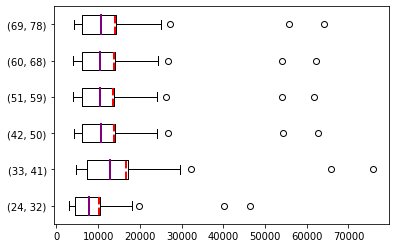

In [12]:
province_age = pd.crosstab(data['province_name'],data['age_range'])
fig, ax = plt.subplots()
ax.boxplot((province_age['A'],province_age['B'],province_age['C'],province_age['D'],province_age['E'],province_age['F'])
            ,vert=False, showmeans=True, meanline=True,meanprops={'linewidth':2,'color':'red'},
          medianprops={'linewidth':2,'color':'purple'}, labels=((24, 32),(33, 41),(42,50),(51,59),(60,68),(69,78)))

According to above graph we understand number of observation in three provinces in all ages are somehow outlier in the range of them ages

In [13]:
# so we sort value of one feature and understanding the huge province observation
province_age['A'].sort_values(ascending=False)

province_name
Tehran                        46371
esfahan                       40145
khorasan razavi               19773
fars                          18014
khoozestan                    13791
kerman                        12246
Kermanshah                    10752
Alborz                        10636
Azarbayjan sharghi            10237
markazi                        9518
Ghom                           9486
Yazd                           9104
chaharmahal va bakhtiyari      8994
Azarbayjan gharbi              8554
Hamedan                        8405
lorestan                       7918
Sistean va Baloochestan        7550
ghazvin                        7405
zanjan                         5737
Khorasan Jonubi                5043
Kordestan                      4981
Mazandaran                     4843
Golestan                       4565
Gilan                          4450
Hormozgan                      4434
ilam                           4423
Kohgilooyeh va booyerahmad     4196
Khorasan shoma

{'whiskers': [<matplotlib.lines.Line2D at 0x277e1d65900>,
 'caps': [<matplotlib.lines.Line2D at 0x277e1d65ea0>,
 'boxes': [<matplotlib.lines.Line2D at 0x277e1d65630>],
 'medians': [<matplotlib.lines.Line2D at 0x277e1d66440>],
 'fliers': [<matplotlib.lines.Line2D at 0x277e1d669e0>],
 'means': [<matplotlib.lines.Line2D at 0x277e1d66710>]}

<Figure size 720x720 with 0 Axes>

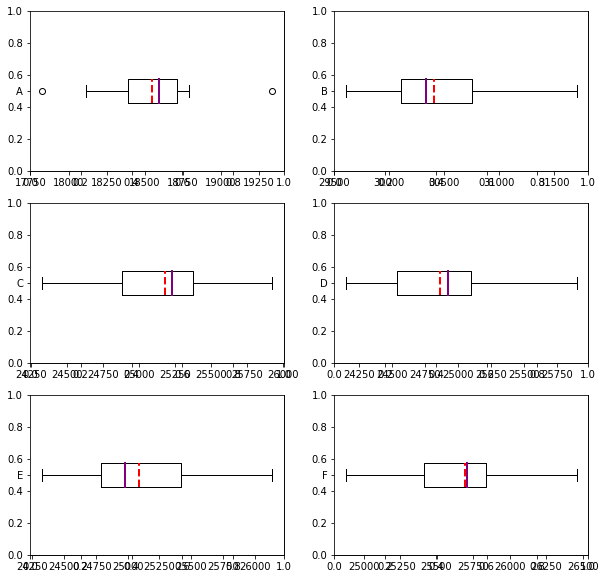

In [14]:
# Now, checking distributed of two dummies value
nationality_age = pd.crosstab(data['nationality'],data['age_range'])
plt.rc('figure', figsize=(10, 10))
plt.subplots_adjust(wspace=1.5, hspace=5)
fig, axes = plt.subplots(3, 2)
ax1 = fig.add_subplot(3, 2, 1) 
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3) 
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6)

ax1.boxplot(nationality_age['A'],vert=False, showmeans=True, meanline=True,
            meanprops={'linewidth':2,'color':'red'},medianprops={'linewidth':2,'color':'purple'},
            labels='A')
ax2.boxplot(nationality_age['B'],vert=False, showmeans=True, meanline=True,
            meanprops={'linewidth':2,'color':'red'},medianprops={'linewidth':2,'color':'purple'},
            labels='B')
ax3.boxplot(nationality_age['C'],vert=False, showmeans=True, meanline=True,
            meanprops={'linewidth':2,'color':'red'},medianprops={'linewidth':2,'color':'purple'},
            labels='C')
ax4.boxplot(nationality_age['D'],vert=False, showmeans=True, meanline=True,
            meanprops={'linewidth':2,'color':'red'},medianprops={'linewidth':2,'color':'purple'},
            labels='D')
ax5.boxplot(nationality_age['E'],vert=False, showmeans=True, meanline=True,
            meanprops={'linewidth':2,'color':'red'},medianprops={'linewidth':2,'color':'purple'},
            labels='E')
ax6.boxplot(nationality_age['F'],vert=False, showmeans=True, meanline=True,
            meanprops={'linewidth':2,'color':'red'},medianprops={'linewidth':2,'color':'purple'},
            labels='F')


  Now, before starting part of probability for investigate of other features and catch more information, let do the normalization on feature. one of the famous way is dividing value of each feature with its mean.

In [15]:
data['payment'] = data['payment']/data['payment'].mean()
data['data_package'] = data['data_package']/data['data_package'].mean()
data['voice'] = data['voice']/data['voice'].mean()
data['data'] = data['data']/data['data'].mean()
data['sms'] = data['sms']/data['sms'].mean()

In [16]:
data.describe()

,age,payment,sms,data,data_package,voice
count,2.546435e+06,2.546435e+06,2.546435e+06,2.546435e+06,2.546435e+06,2.546435e+06
mean,5.081124e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
std,1.560511e+01,1.412253e+00,3.450518e+00,4.336174e+00,1.857809e+00,1.675597e+00
min,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.700000e+01,0.000000e+00,2.422152e-02,0.000000e+00,0.000000e+00,6.177407e-02
50%,5.100000e+01,4.601483e-01,2.131181e-01,0.000000e+00,0.000000e+00,4.065787e-01
75%,6.400000e+01,1.503151e+00,7.859963e-01,2.434082e-01,1.523300e+00,1.259493e+00
max,7.800000e+01,5.027888e+02,6.771948e+02,1.272490e+03,5.128809e+01,1.492647e+02


In [17]:
# remove 'age' feature and keep the 'age_range'
data.drop('age', axis = 1, inplace = True)

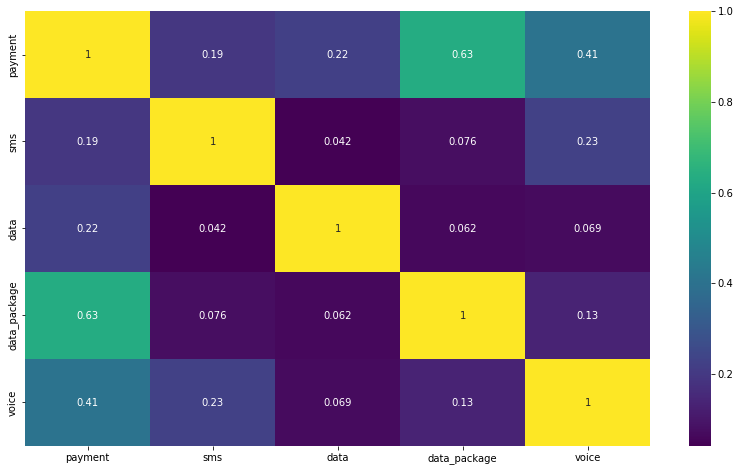

In [18]:
plt.figure(figsize=(14,8))
sns.heatmap(data.corr(),annot=True,cmap='viridis');

According to heatmap graph, the feature that has the most relation with other is 'payment' and the less one is 'data'. it shows that the most observations are using data_package and don't use PAYG

#### Payment distribution and calculate some probabilities

According to describe of data, the distance between 3rd quantile and max is huge so for take acceptable distribution graph the last quarter of information is ommites

Text(0.5, 1.0, 'Payments occurence till the 3rd quantile')

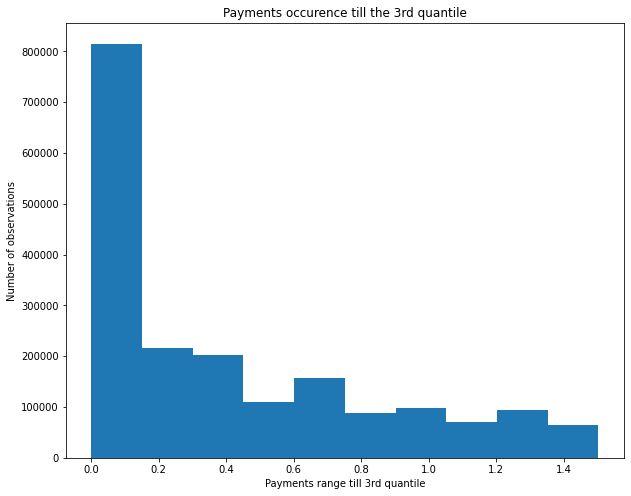

In [19]:
temp = data[data['payment'] <= np.quantile(data['payment'],.75)]['payment']
_ , bin_edges = np.histogram(temp, bins = 10)
plt.rc('figure', figsize=(10, 8))
fig , ax = plt.subplots()
ax.hist(temp, bin_edges, cumulative=False)
ax.set_xlabel('Payments range till 3rd quantile')
ax.set_ylabel('Number of observations')
ax.set_title('Payments occurence till the 3rd quantile')

Based on above histogram of payment distribution, we can get it the range of subscribers that paid less is huge, so in probability part we focus on not paid subscribers as well

In [20]:
def probability(n, s):
    return len(pd.merge(n, s, how='inner')) / len(s)

def complements(n, s):
    return pd.concat([n,s]).drop_duplicates(keep=False)

def intersect(a, b):
    return pd.merge(a, b, how='inner')

def union(a, b):
    return pd.merge(a, b, how='outer')

def prob_intersect(a, b, s):
    return len(pd.merge(a, b, how='inner')) / len(s)

In [21]:
# serial number is usede as unique identifier here so we can use it to create the sample spaces
All_observation = data['serial_number']
A_NotPaid = data[data['payment'] == 0]['serial_number']
A_Paid = complements(A_NotPaid, All_observation)
A_lessPaid = data[data['payment'] < data['payment'].mean()]['serial_number']
A_lessPaid_without_NotPayment = intersect(A_lessPaid, A_Paid)
A_upper_mean = data[data['payment'] >= data['payment'].mean()]['serial_number']
A_upper_95 = data[data['payment'] >= np.quantile(data['payment'],.95)]['serial_number']

In [22]:
Pnot_payment = probability(A_NotPaid, All_observation)
Pless_than_mean = probability(A_lessPaid_without_NotPayment, All_observation)
Pmore_than_mean = probability(A_upper_mean, All_observation)
Pmore_than_95 = probability(A_upper_95, All_observation)
Payment_probability = [Pnot_payment, Pless_than_mean, Pmore_than_mean, Pmore_than_95]
print('''probability the observation that has no payment in next month: {0}
probability the observation that payment less than mean exclude no payment of population: {1}
probability the observation that payment more than mean of population: {2}
probability the observation that payment more than 95% of population: {3}'''
.format(Payment_probability[0],Payment_probability[1],Payment_probability[2],Payment_probability[3]))

probability the observation that has no payment in next month: 0.25228878805074545
probability the observation that payment less than mean exclude no payment of population: 0.40170041646458676
probability the observation that payment more than mean of population: 0.3460107954846678
probability the observation that payment more than 95% of population: 0.0512233769956822


In [23]:
# check the probability defined functions
Payment_probability[0]+Payment_probability[1]+Payment_probability[2] == 1

True

#### calculate of probability of payment with activation package
1. probability of susbcribers that doesn't have payment
2. probability of subscribers that have payment less than mean
3. probability of subscribers that have payment more than mean

because the activation package probability is the independed to other features probability so the conditional probability is not useful here

In [24]:
P_act_pa = [0.5, 0.25, 0.15, 0.07, 0.03]
probability_table = PrettyTable(["very low quota", "low quota", "medium quota", "high quota","very high quota"])
s = np.ones((len(Payment_probability), len(P_act_pa)))
for i in range(len(Payment_probability)):
    for j in range(len(P_act_pa)):
        s[i,j] = P_act_pa[j] * Payment_probability[i]
        
for i in range(len(Payment_probability)):
    A = s[i,:].tolist()
    probability_table.add_row(A)
probability_table.add_column('Payment_probability',['no payment','less than mean exclude no payment','more than mean','more than 95%'])

In [25]:
probability_table

very low quota,low quota,medium quota,high quota,very high quota,Payment_probability
0.12614439402537272,0.06307219701268636,0.03784331820761182,0.017660215163552182,0.007568663641522363,no payment
0.20085020823229338,0.10042510411614669,0.06025506246968801,0.028119029152521076,0.012051012493937602,less than mean exclude no payment
0.1730053977423339,0.08650269887116695,0.05190161932270017,0.02422075568392675,0.010380323864540034,more than mean
0.0256116884978411,0.01280584424892055,0.007683506549352329,0.0035856363896977542,0.0015367013098704658,more than 95%


#### next calculate of probability of payment with usage of services
    we want to find two different conditional probabilities
    1. based on subscribers payment
    2. based on usage

Before that looking to usage distribution

Text(0.5, 1.0, 'Data occurence till the 3rd quantile')

<Figure size 1440x1440 with 0 Axes>

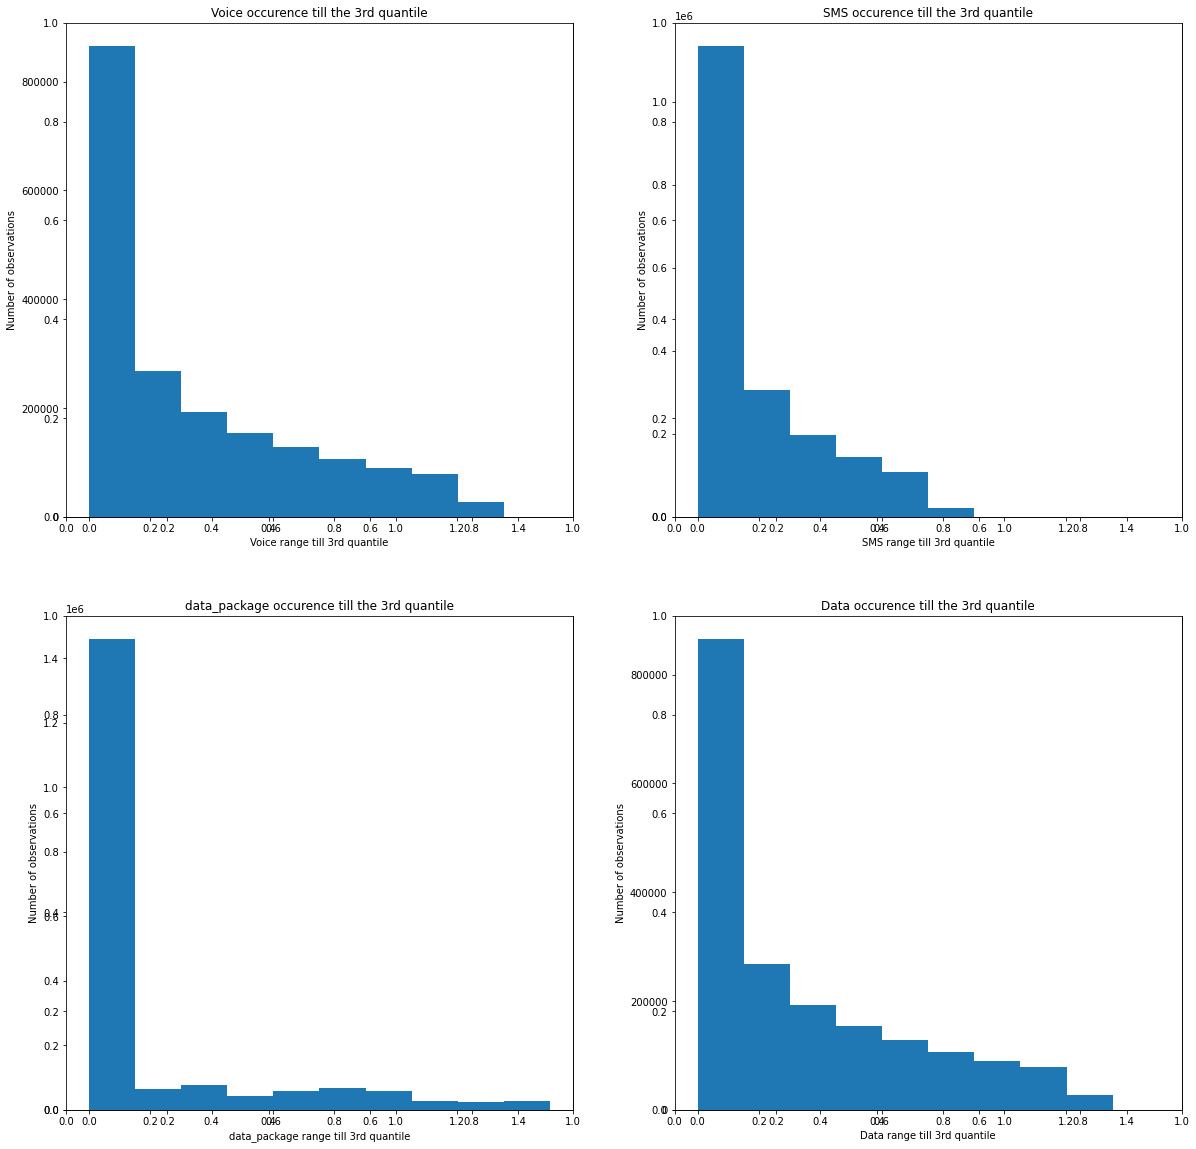

In [26]:
plt.rc('figure', figsize=(20, 20))
plt.subplots_adjust(wspace=1.5, hspace=5)
fig, axes = plt.subplots(2, 2)
ax1 = fig.add_subplot(2, 2, 1) 
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3) 
ax4 = fig.add_subplot(2, 2, 4)

temp1 = data[data['voice'] <= np.quantile(data['voice'],.75)]['voice']
_ , bin_edges = np.histogram(temp, bins = 10)

ax1.hist(temp1, bin_edges, cumulative=False)
ax1.set_xlabel('Voice range till 3rd quantile')
ax1.set_ylabel('Number of observations')
ax1.set_title('Voice occurence till the 3rd quantile')

temp2 = data[data['sms'] <= np.quantile(data['sms'],.75)]['sms']
_ , bin_edges = np.histogram(temp, bins = 10)

ax2.hist(temp2, bin_edges, cumulative=False)
ax2.set_xlabel('SMS range till 3rd quantile')
ax2.set_ylabel('Number of observations')
ax2.set_title('SMS occurence till the 3rd quantile')

temp3 = data[data['data_package'] <= np.quantile(data['data_package'],.75)]['data_package']
_ , bin_edges = np.histogram(temp, bins = 10)

ax3.hist(temp3, bin_edges, cumulative=False)
ax3.set_xlabel('data_package range till 3rd quantile')
ax3.set_ylabel('Number of observations')
ax3.set_title('data_package occurence till the 3rd quantile')

temp4 = data[data['voice'] <= np.quantile(data['voice'],.75)]['voice']
_ , bin_edges = np.histogram(temp, bins = 10)

ax4.hist(temp4, bin_edges, cumulative=False)
ax4.set_xlabel('Data range till 3rd quantile')
ax4.set_ylabel('Number of observations')
ax4.set_title('Data occurence till the 3rd quantile')

Output of usage shows that, the data doesn't have normal distribution

#### in this step we separate the usage range to
1. less than first quantile
2. between first quantile and median
3. between median and third quantile
4. between third quantile and 0.95 of usage

according to describe table and above information the 0.95 of information are included most of them and no need to include outliers of last 5%

In [27]:
All_observation = data['serial_number']
# less than first quantile # because there is large group of subscribers without payment so 
A_P_l_1q = data[data['payment'] <= np.quantile(data['payment'],.25)]['serial_number']
# between first quantile and median
A_P_l_median = data[data['payment'] < np.quantile(data['payment'],.5)]['serial_number']
A_P_l_median_g_1q = intersect(A_P_l_median, complements(A_P_l_1q, All_observation))
# between median and third quantile
A_P_g_median = complements(A_P_l_median, All_observation)
A_P_l_3q = data[data['payment'] < np.quantile(data['payment'],.75)]['serial_number']
A_P_g_median_1_3q = intersect(A_P_l_3q, A_P_g_median)
# between third quantile and 0.95 of usage
A_P_g_3q = complements(A_P_l_3q, All_observation)
A_P_l_95 = data[data['payment'] < np.quantile(data['payment'],.95)]['serial_number']
A_P_l_95_g_3q = intersect(A_P_g_3q, A_P_l_95)

A_Payment_observation = [A_P_l_1q, A_P_l_median_g_1q, A_P_g_median_1_3q, A_P_l_95_g_3q]


In [28]:
All_observation = data['serial_number']
# less than first quantile
A_V_l_1q = data[data['voice'] <= np.quantile(data['voice'],.25)]['serial_number']
# between first quantile and median
A_V_l_median = data[data['voice'] < np.quantile(data['voice'],.5)]['serial_number']
A_V_l_median_g_1q = intersect(A_V_l_median, complements(A_V_l_1q, All_observation))
# between median and third quantile
A_V_g_median = complements(A_V_l_median, All_observation)
A_V_l_3q = data[data['voice'] < np.quantile(data['voice'],.75)]['serial_number']
A_V_g_median_1_3q = intersect(A_V_l_3q, A_V_g_median)
# between third quantile and 0.95 of usage
A_V_g_3q = complements(A_V_l_3q, All_observation)
A_V_l_95 = data[data['voice'] < np.quantile(data['voice'],.95)]['serial_number']
A_V_l_95_g_3q = intersect(A_V_g_3q, A_V_l_95)

A_Voice_observation = [A_V_l_1q, A_V_l_median_g_1q, A_V_g_median_1_3q, A_V_l_95_g_3q]

# addition the probability of different of voice usage
P_l_1q = probability(A_V_l_1q,All_observation)
P_l_median_g_1q = probability(A_V_l_median_g_1q,All_observation)
P_l_3q_g_median = probability(A_V_g_median_1_3q,All_observation)
P_l_95_g_3q = probability(A_V_l_95_g_3q,All_observation)

Probability_Voice = [P_l_1q, P_l_median_g_1q, P_l_3q_g_median, P_l_95_g_3q]
print('''probability the observation that has usage of voice lesser than 1q in next month: {0}
probability the observation that has usage of voice lesser than median greater than 1q: {1}
probability the observation that has usage of voice lesser than 3q greater than median: {2}
probability the observation that has usage of voice lesser than 95% greater than 3q: {3}'''
.format(Probability_Voice[0],Probability_Voice[1],Probability_Voice[2],Probability_Voice[3]))

probability the observation that has usage of voice lesser than 1q in next month: 0.2500315146469476
probability the observation that has usage of voice lesser than median greater than 1q: 0.24996828900011192
probability the observation that has usage of voice lesser than 3q greater than median: 0.24999774194118443
probability the observation that has usage of voice lesser than 95% greater than 3q: 0.1999988218823571


In [29]:
Payment_Voice = PrettyTable(['less than first quantile', 'between first quantile and median',
                             'between median and third quantile', 'between third quantile and 0.95 of usage'])
s = np.ones((len(A_Payment_observation), len(A_Voice_observation)))
for i in range(len(A_Payment_observation)):
    for j in range(len(A_Voice_observation)):
        s[i,j] = prob_intersect(A_Payment_observation[i],A_Voice_observation[j],All_observation)/Probability_Voice[i]

for i in range(len(A_Payment_observation)):
    A = s[i,:].tolist()
    Payment_Voice.add_row(A)
Payment_Voice.add_column('A_Voice_observation',['less than first quantile', 'between first quantile and median',
                             'between median and third quantile', 'between third quantile and 0.95 of usage'])

In [30]:
Payment_Voice

less than first quantile,between first quantile and median,between median and third quantile,between third quantile and 0.95 of usage,A_Voice_observation
0.6147522573815473,0.20843300261195022,0.11128510151738132,0.06068739997078636,less than first quantile
0.18197785486262977,0.32551435286428876,0.3220313953196089,0.0983271749239625,between first quantile and median
0.13504020559123975,0.2702453491422441,0.29245856522825053,0.3192444898940156,between median and third quantile
0.07302016163869275,0.2070082704345709,0.2819644834709121,0.31843725701180486,between third quantile and 0.95 of usage


In [31]:
Voice_payment = PrettyTable(['less than first quantile', 'between first quantile and median',
                             'between median and third quantile', 'between third quantile and 0.95 of usage'])
s = np.ones((len(A_Payment_observation), len(A_Voice_observation)))
for i in range(len(A_Payment_observation)):
    for j in range(len(A_Voice_observation)):
        s[i,j] = prob_intersect(A_Payment_observation[i],A_Voice_observation[j],All_observation)/probability(A_Payment_observation[i],All_observation)

for i in range(len(A_Payment_observation)):
    A = s[i,:].tolist()
    Voice_payment.add_row(A)
Voice_payment.add_column('A_Voice_observation',['less than first quantile', 'between first quantile and median',
                             'between median and third quantile', 'between third quantile and 0.95 of usage'])

In [32]:
Voice_payment

less than first quantile,between first quantile and median,between median and third quantile,between third quantile and 0.95 of usage,A_Voice_observation
0.6092519577795177,0.20656811485017207,0.11028941359230555,0.060144418830173234,less than first quantile
0.1957267051358955,0.3501077194731461,0.3463616163834982,0.10575602172976352,between first quantile and median
0.12730363650633578,0.25476276153539734,0.275703363438873,0.30095469952953613,between median and third quantile
0.07342804395257228,0.20816459507754884,0.2835395049905717,0.32021601129419197,between third quantile and 0.95 of usage


In [33]:
All_observation = data['serial_number']
# less than first quantile
A_S_l_1q = data[data['sms'] <= np.quantile(data['sms'],.25)]['serial_number']
# between first quantile and median
A_S_l_median = data[data['sms'] < np.quantile(data['sms'],.5)]['serial_number']
A_S_l_median_g_1q = intersect(A_S_l_median, complements(A_S_l_1q, All_observation))
# between median and third quantile
A_S_g_median = complements(A_S_l_median, All_observation)
A_S_l_3q = data[data['sms'] < np.quantile(data['sms'],.75)]['serial_number']
A_S_g_median_1_3q = intersect(A_S_l_3q, A_S_g_median)
# between third quantile and 0.95 of usage
A_S_g_3q = complements(A_S_l_3q, All_observation)
A_S_l_95 = data[data['sms'] < np.quantile(data['sms'],.95)]['serial_number']
A_S_l_95_g_3q = intersect(A_S_g_3q, A_S_l_95)

A_SMS_observation = [A_S_l_1q, A_S_l_median_g_1q, A_S_g_median_1_3q, A_S_l_95_g_3q]

# addition the probability of different of sms usage
P_l_1q = probability(A_S_l_1q,All_observation)
P_l_median_g_1q = probability(A_S_l_median_g_1q,All_observation)
P_l_3q_g_median = probability(A_S_g_median_1_3q,All_observation)
P_l_95_g_3q = probability(A_S_l_95_g_3q,All_observation)

Probability_SMS = [P_l_1q, P_l_median_g_1q, P_l_3q_g_median, P_l_95_g_3q]
print('''probability the observation that has usage of sms lesser than 1q in next month: {0}
probability the observation that has usage of sms lesser than median greater than 1q: {1}
probability the observation that has usage of sms lesser than 3q greater than median: {2}
probability the observation that has usage of sms lesser than 95% greater than 3q: {3}'''
.format(Probability_SMS[0],Probability_SMS[1],Probability_SMS[2],Probability_SMS[3]))

probability the observation that has usage of sms lesser than 1q in next month: 0.25394482875078295
probability the observation that has usage of sms lesser than median greater than 1q: 0.24528802031074817
probability the observation that has usage of sms lesser than 3q greater than median: 0.25076587464435574
probability the observation that has usage of sms lesser than 95% greater than 3q: 0.19999921458823808


In [34]:
Payment_SMS = PrettyTable(['less than first quantile', 'between first quantile and median',
                             'between median and third quantile', 'between third quantile and 0.95 of usage'])
s = np.ones((len(A_Payment_observation), len(A_SMS_observation)))
for i in range(len(A_Payment_observation)):
    for j in range(len(A_SMS_observation)):
        s[i,j] = prob_intersect(A_Payment_observation[i],A_SMS_observation[j],All_observation)/Probability_SMS[i]

for i in range(len(A_Payment_observation)):
    A = s[i,:].tolist()
    Payment_SMS.add_row(A)
Payment_SMS.add_column('A_SMS_observation',['less than first quantile', 'between first quantile and median',
                             'between median and third quantile', 'between third quantile and 0.95 of usage'])

In [43]:
Payment_SMS

less than first quantile,between first quantile and median,between median and third quantile,between third quantile and 0.95 of usage,A_SMS_observation
0.5795015572469976,0.20062506378990927,0.1334376652738559,0.07041942058658882,less than first quantile
0.19744000256159844,0.3071980916091641,0.2710347256688173,0.15340612542226348,between first quantile and median
0.1425929318982271,0.26624164720879356,0.3153021099068371,0.27085985789880024,between median and third quantile
0.09366857457023081,0.21451446635970037,0.2888893252304702,0.2987914429052495,between third quantile and 0.95 of usage


In [44]:
SMS_payment = PrettyTable(['less than first quantile', 'between first quantile and median',
                             'between median and third quantile', 'between third quantile and 0.95 of usage'])
s = np.ones((len(A_Payment_observation), len(A_SMS_observation)))
for i in range(len(A_Payment_observation)):
    for j in range(len(A_SMS_observation)):
        s[i,j] = prob_intersect(A_Payment_observation[i],A_SMS_observation[j],All_observation)/probability(A_Payment_observation[i],All_observation)

for i in range(len(A_Payment_observation)):
    A = s[i,:].tolist()
    SMS_payment.add_row(A)
SMS_payment.add_column('A_SMS_observation',['less than first quantile', 'between first quantile and median',
                             'between median and third quantile', 'between third quantile and 0.95 of usage'])

In [45]:
SMS_payment

less than first quantile,between first quantile and median,between median and third quantile,between third quantile and 0.95 of usage,A_SMS_observation
0.5833054447362154,0.201941980303127,0.13431355915054705,0.07088165843499052,less than first quantile
0.2083809974400784,0.32422125157354914,0.28605391887667597,0.161907014861063,between first quantile and median
0.13483668522163036,0.2517596117821798,0.2981514635912518,0.25612661800616326,between median and third quantile
0.09419198151859494,0.21571314331974212,0.29050359854281227,0.3004610478719728,between third quantile and 0.95 of usage


In [46]:
All_observation = data['serial_number']
# less than first quantile
A_DP_l_1q = data[data['data_package'] <= np.quantile(data['data_package'],.25)]['serial_number']
# between first quantile and median
A_DP_l_median = data[data['data_package'] < np.quantile(data['data_package'],.5)]['serial_number']
A_DP_l_median_g_1q = intersect(A_DP_l_median, complements(A_DP_l_1q, All_observation))
# between median and third quantile
A_DP_g_median = complements(A_DP_l_median, All_observation)
A_DP_l_3q = data[data['data_package'] < np.quantile(data['data_package'],.75)]['serial_number']
A_DP_g_median_1_3q = intersect(A_DP_l_3q, A_DP_g_median)
# between third quantile and 0.95 of usage
A_DP_g_3q = complements(A_DP_l_3q, All_observation)
A_DP_l_95 = data[data['data_package'] < np.quantile(data['data_package'],.95)]['serial_number']
A_DP_l_95_g_3q = intersect(A_DP_g_3q, A_DP_l_95)

A_data_package_observation = [A_DP_l_1q, A_DP_l_median_g_1q, A_DP_g_median_1_3q, A_DP_l_95_g_3q]

# addition the probability of different of data_package usage
P_l_1q = probability(A_DP_l_1q,All_observation)
P_l_median_g_1q = probability(A_DP_l_median_g_1q,All_observation)
P_l_3q_g_median = probability(A_DP_g_median_1_3q,All_observation)
P_l_95_g_3q = probability(A_DP_l_95_g_3q,All_observation)

Probability_data_package = [P_l_1q, P_l_median_g_1q, P_l_3q_g_median, P_l_95_g_3q]
print('''probability the observation that has usage of data_package lesser than 1q in next month: {0}
probability the observation that has usage of data_package lesser than median greater than 1q: {1}
probability the observation that has usage of data_package lesser than 3q greater than median: {2}
probability the observation that has usage of data_package lesser than 95% greater than 3q: {3}'''
.format(Probability_data_package[0],Probability_data_package[1],Probability_data_package[2],Probability_data_package[3]))

probability the observation that has usage of data_package lesser than 1q in next month: 0.5042779415143132
probability the observation that has usage of data_package lesser than median greater than 1q: 0.0
probability the observation that has usage of data_package lesser than 3q greater than median: 0.7497018380598759
probability the observation that has usage of data_package lesser than 95% greater than 3q: 0.2002980637636539


In [47]:
# according to above result that shows the most than 50% of subsribers doesn't have any data_package usage, we need to omit
A_DP_observation = [A_DP_l_1q, A_DP_g_median_1_3q, A_DP_l_95_g_3q]
Probability_DP = [P_l_1q, P_l_3q_g_median, P_l_95_g_3q]
Payment_DP = PrettyTable(['less than first quantile', 'between first quantile and median',
                             'between median and third quantile', 'between third quantile and 0.95 of usage'])
s = np.ones((len(A_DP_observation), len(A_Payment_observation)))
for i in range(len(A_DP_observation)):
    for j in range(len(A_Payment_observation)):
        s[i,j] = prob_intersect(A_Payment_observation[j],A_DP_observation[i],All_observation)/Probability_DP[i]

for i in range(len(A_DP_observation)):
    A = s[i,:].tolist()
    Payment_DP.add_row(A)
Payment_DP.add_column('A_DataPackage_observation',['less than first quantile', 'between median and third quantile',
                                           'between third quantile and 0.95 of usage'])

In [48]:
Payment_DP

less than first quantile,between first quantile and median,between median and third quantile,between third quantile and 0.95 of usage,A_DataPackage_observation
0.4227562882024996,0.3236550422821703,0.20176526795580754,0.043202651484178546,less than first quantile
0.31822403299622276,0.30133882152905056,0.2933684359951746,0.07812402602946884,between median and third quantile
0.05278347443171793,0.026221164365567026,0.20117989357822627,0.6091254514298711,between third quantile and 0.95 of usage


In [49]:
All_observation = data['serial_number']
# less than first quantile
A_D_l_1q = data[data['data'] <= np.quantile(data['data'],.25)]['serial_number']
# between first quantile and median
A_D_l_median = data[data['data'] < np.quantile(data['data'],.5)]['serial_number']
A_D_l_median_g_1q = intersect(A_D_l_median, complements(A_D_l_1q, All_observation))
# between median and third quantile
A_D_g_median = complements(A_D_l_median, All_observation)
A_D_l_3q = data[data['data'] < np.quantile(data['data'],.75)]['serial_number']
A_D_g_median_1_3q = intersect(A_D_l_3q, A_D_g_median)
# between third quantile and 0.95 of usage
A_D_g_3q = complements(A_D_l_3q, All_observation)
A_D_l_95 = data[data['data'] < np.quantile(data['data'],.95)]['serial_number']
A_D_l_95_g_3q = intersect(A_D_g_3q, A_D_l_95)

A_data_observation = [A_D_l_1q, A_D_l_median_g_1q, A_D_g_median_1_3q, A_D_l_95_g_3q]

# addition the probability of different of data usage
P_l_1q = probability(A_D_l_1q,All_observation)
P_l_median_g_1q = probability(A_D_l_median_g_1q,All_observation)
P_l_3q_g_median = probability(A_D_g_median_1_3q,All_observation)
P_l_95_g_3q = probability(A_D_l_95_g_3q,All_observation)

Probability_data = [P_l_1q, P_l_median_g_1q, P_l_3q_g_median, P_l_95_g_3q]
print('''probability the observation that has usage of data lesser than 1q in next month: {0}
probability the observation that has usage of data lesser than median greater than 1q: {1}
probability the observation that has usage of data lesser than 3q greater than median: {2}
probability the observation that has usage of data lesser than 95% greater than 3q: {3}'''
.format(Probability_data[0],Probability_data[1],Probability_data[2],Probability_data[3]))

probability the observation that has usage of data lesser than 1q in next month: 0.607491650091206
probability the observation that has usage of data lesser than median greater than 1q: 0.0
probability the observation that has usage of data lesser than 3q greater than median: 0.7499983310000059
probability the observation that has usage of data lesser than 95% greater than 3q: 0.20000157082352388


In [50]:
# according to above result that shows the most than 50% of subsribers doesn't have any data_package usage, we need to omit
A_D_observation = [A_D_l_1q, A_D_g_median_1_3q, A_D_l_95_g_3q]
Probability_D = [P_l_1q, P_l_3q_g_median, P_l_95_g_3q]
Payment_Data = PrettyTable(['less than first quantile', 'between first quantile and median',
                             'between median and third quantile', 'between third quantile and 0.95 of usage'])
s = np.ones((len(A_D_observation), len(A_Payment_observation)))
for i in range(len(A_D_observation)):
    for j in range(len(A_Payment_observation)):
        s[i,j] = prob_intersect(A_Payment_observation[j],A_D_observation[i],All_observation)/Probability_D[i]

for i in range(len(A_D_observation)):
    A = s[i,:].tolist()
    Payment_Data.add_row(A)
Payment_Data.add_column('A_Data_observation',['less than first quantile', 'between median and third quantile',
                                           'between third quantile and 0.95 of usage'])

In [51]:
Payment_Data

less than first quantile,between first quantile and median,between median and third quantile,between third quantile and 0.95 of usage,A_Data_observation
0.3137061730980815,0.2173454915452332,0.23908715152126325,0.18319286228665918,less than first quantile
0.301020723397259,0.2275683283573024,0.24313522412036304,0.18219603711759524,between median and third quantile
0.11734941320384613,0.2914365264652232,0.33134298465906525,0.21742186686982493,between third quantile and 0.95 of usage


As before mentioned two feature in dataset exist that we can do cluster sampling and find above value for the whole dataset without their affection
1. province_name
2. payment_type

In [52]:
Province = sorted(data['province_name'].unique())
first = Province.pop()
sample_size = data.groupby('province_name').count()['serial_number'].min()

S_Data = data[data.province_name == first].sample(n=sample_size)
for i in Province:
    sample_data = data[data.province_name == i].sample(n=sample_size)
    S_Data = pd.concat([S_Data,sample_data],axis=0)

In [53]:
S_D_pre = data[data.payment_type == 'PRE'].sample(n=100000)
S_D_pos = data[data.payment_type == 'POS'].sample(n=100000)
S_D_Ptype = pd.concat([S_D_pre,S_D_pos],axis=0)

#### First check the some probabilities with clustring of province

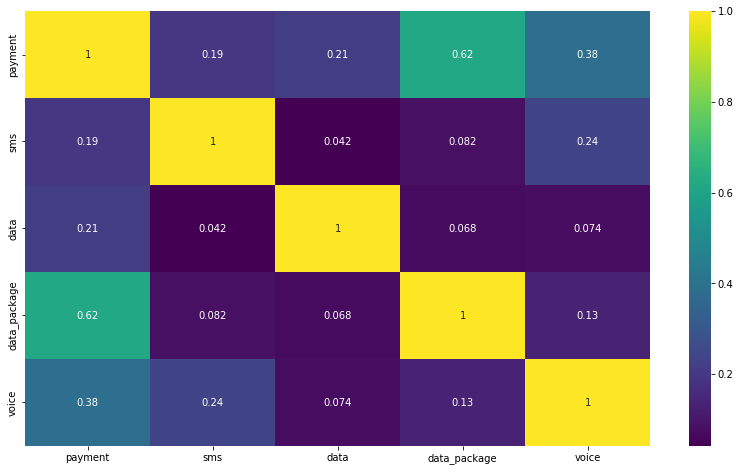

In [54]:
plt.figure(figsize=(14,8))
sns.heatmap(S_Data.corr(),annot=True,cmap='viridis');

In [55]:
All_observation = S_Data['serial_number']
A_NotPaid = S_Data[S_Data['payment'] == 0]['serial_number']
A_Paid = complements(A_NotPaid, All_observation)
A_lessPaid = S_Data[S_Data['payment'] < S_Data['payment'].mean()]['serial_number']
A_lessPaid_without_NotPayment = intersect(A_lessPaid, A_Paid)
A_upper_mean = S_Data[S_Data['payment'] >= S_Data['payment'].mean()]['serial_number']
A_upper_95 = S_Data[S_Data['payment'] >= np.quantile(S_Data['payment'],.95)]['serial_number']

Pnot_payment = probability(A_NotPaid, All_observation)
Pless_than_mean = probability(A_lessPaid_without_NotPayment, All_observation)
Pmore_than_mean = probability(A_upper_mean, All_observation)
Pmore_than_95 = probability(A_upper_95, All_observation)
Payment_probability = [Pnot_payment, Pless_than_mean, Pmore_than_mean, Pmore_than_95]
print('''probability the observation that has no payment in next month: {0}
probability the observation that payment less than mean exclude no payment of population: {1}
probability the observation that payment more than mean of population: {2}
probability the observation that payment more than 95% of population: {3}'''
.format(Payment_probability[0],Payment_probability[1],Payment_probability[2],Payment_probability[3]))

probability the observation that has no payment in next month: 0.2496718143870673
probability the observation that payment less than mean exclude no payment of population: 0.4036542244427549
probability the observation that payment more than mean of population: 0.3466739611701778
probability the observation that payment more than 95% of population: 0.050121552710162824


In [56]:
All_observation = S_Data['serial_number']
# less than first quantile
A_V_l_1q = S_Data[S_Data['voice'] <= np.quantile(S_Data['voice'],.25)]['serial_number']
# between first quantile and median
A_V_l_median = S_Data[S_Data['voice'] < np.quantile(S_Data['voice'],.5)]['serial_number']
A_V_l_median_g_1q = intersect(A_V_l_median, complements(A_V_l_1q, All_observation))
# between median and third quantile
A_V_g_median = complements(A_V_l_median, All_observation)
A_V_l_3q = S_Data[S_Data['voice'] < np.quantile(S_Data['voice'],.75)]['serial_number']
A_V_g_median_1_3q = intersect(A_V_l_3q, A_V_g_median)
# between third quantile and 0.95 of usage
A_V_g_3q = complements(A_V_l_3q, All_observation)
A_V_l_95 = S_Data[S_Data['voice'] < np.quantile(S_Data['voice'],.95)]['serial_number']
A_V_l_95_g_3q = intersect(A_V_g_3q, A_V_l_95)

A_Voice_observation = [A_V_l_1q, A_V_l_median_g_1q, A_V_g_median_1_3q, A_V_l_95_g_3q]

# addition the probability of different of voice usage
P_l_1q = probability(A_V_l_1q,All_observation)
P_l_median_g_1q = probability(A_V_l_median_g_1q,All_observation)
P_l_3q_g_median = probability(A_V_g_median_1_3q,All_observation)
P_l_95_g_3q = probability(A_V_l_95_g_3q,All_observation)

Probability_Voice = [P_l_1q, P_l_median_g_1q, P_l_3q_g_median, P_l_95_g_3q]
print('''probability the observation that has usage of voice lesser than 1q in next month: {0}
probability the observation that has usage of voice lesser than median greater than 1q: {1}
probability the observation that has usage of voice lesser than 3q greater than median: {2}
probability the observation that has usage of voice lesser than 95% greater than 3q: {3}'''
.format(Probability_Voice[0],Probability_Voice[1],Probability_Voice[2],Probability_Voice[3]))

probability the observation that has usage of voice lesser than 1q in next month: 0.25008615291371167
probability the observation that has usage of voice lesser than median greater than 1q: 0.24988904041074492
probability the observation that has usage of voice lesser than 3q greater than median: 0.2500164260419139
probability the observation that has usage of voice lesser than 95% greater than 3q: 0.20000750904773207


In [57]:
All_observation = S_Data['serial_number']
# less than first quantile
A_S_l_1q = S_Data[S_Data['sms'] <= np.quantile(S_Data['sms'],.25)]['serial_number']
# between first quantile and median
A_S_l_median = S_Data[S_Data['sms'] < np.quantile(S_Data['sms'],.5)]['serial_number']
A_S_l_median_g_1q = intersect(A_S_l_median, complements(A_S_l_1q, All_observation))
# between median and third quantile
A_S_g_median = complements(A_S_l_median, All_observation)
A_S_l_3q = S_Data[S_Data['sms'] < np.quantile(S_Data['sms'],.75)]['serial_number']
A_S_g_median_1_3q = intersect(A_S_l_3q, A_S_g_median)
# between third quantile and 0.95 of usage
A_S_g_3q = complements(A_S_l_3q, All_observation)
A_S_l_95 = S_Data[S_Data['sms'] < np.quantile(S_Data['sms'],.95)]['serial_number']
A_S_l_95_g_3q = intersect(A_S_g_3q, A_S_l_95)

A_SMS_observation = [A_S_l_1q, A_S_l_median_g_1q, A_S_g_median_1_3q, A_S_l_95_g_3q]

# addition the probability of different of sms usage
P_l_1q = probability(A_S_l_1q,All_observation)
P_l_median_g_1q = probability(A_S_l_median_g_1q,All_observation)
P_l_3q_g_median = probability(A_S_g_median_1_3q,All_observation)
P_l_95_g_3q = probability(A_S_l_95_g_3q,All_observation)

Probability_SMS = [P_l_1q, P_l_median_g_1q, P_l_3q_g_median, P_l_95_g_3q]
print('''probability the observation that has usage of sms lesser than 1q in next month: {0}
probability the observation that has usage of sms lesser than median greater than 1q: {1}
probability the observation that has usage of sms lesser than 3q greater than median: {2}
probability the observation that has usage of sms lesser than 95% greater than 3q: {3}'''
.format(Probability_SMS[0],Probability_SMS[1],Probability_SMS[2],Probability_SMS[3]))

probability the observation that has usage of sms lesser than 1q in next month: 0.25245150294931257
probability the observation that has usage of sms lesser than median greater than 1q: 0.24754648569861631
probability the observation that has usage of sms lesser than 3q greater than median: 0.2500016761267259
probability the observation that has usage of sms lesser than 95% greater than 3q: 0.199998122738067


In [58]:
All_observation = S_Data['serial_number']
# less than first quantile
A_DP_l_1q = S_Data[S_Data['data_package'] <= np.quantile(S_Data['data_package'],.25)]['serial_number']
# between first quantile and median
A_DP_l_median = S_Data[S_Data['data_package'] < np.quantile(S_Data['data_package'],.5)]['serial_number']
A_DP_l_median_g_1q = intersect(A_DP_l_median, complements(A_DP_l_1q, All_observation))
# between median and third quantile
A_DP_g_median = complements(A_DP_l_median, All_observation)
A_DP_l_3q = S_Data[S_Data['data_package'] < np.quantile(S_Data['data_package'],.75)]['serial_number']
A_DP_g_median_1_3q = intersect(A_DP_l_3q, A_DP_g_median)
# between third quantile and 0.95 of usage
A_DP_g_3q = complements(A_DP_l_3q, All_observation)
A_DP_l_95 = S_Data[S_Data['data_package'] < np.quantile(S_Data['data_package'],.95)]['serial_number']
A_DP_l_95_g_3q = intersect(A_DP_g_3q, A_DP_l_95)

A_data_package_observation = [A_DP_l_1q, A_DP_l_median_g_1q, A_DP_g_median_1_3q, A_DP_l_95_g_3q]

# addition the probability of different of data_package usage
P_l_1q = probability(A_DP_l_1q,All_observation)
P_l_median_g_1q = probability(A_DP_l_median_g_1q,All_observation)
P_l_3q_g_median = probability(A_DP_g_median_1_3q,All_observation)
P_l_95_g_3q = probability(A_DP_l_95_g_3q,All_observation)

Probability_data_package = [P_l_1q, P_l_median_g_1q, P_l_3q_g_median, P_l_95_g_3q]
print('''probability the observation that has usage of data_package lesser than 1q in next month: {0}
probability the observation that has usage of data_package lesser than median greater than 1q: {1}
probability the observation that has usage of data_package lesser than 3q greater than median: {2}
probability the observation that has usage of data_package lesser than 95% greater than 3q: {3}'''
.format(Probability_data_package[0],Probability_data_package[1],Probability_data_package[2],Probability_data_package[3]))

probability the observation that has usage of data_package lesser than 1q in next month: 0.4930132333557264
probability the observation that has usage of data_package lesser than median greater than 1q: 0.00632771361564671
probability the observation that has usage of data_package lesser than 3q greater than median: 0.25065871780328175
probability the observation that has usage of data_package lesser than 95% greater than 3q: 0.1999994636394477


In [59]:
All_observation = S_Data['serial_number']
# less than first quantile
A_D_l_1q = S_Data[S_Data['data'] <= np.quantile(S_Data['data'],.25)]['serial_number']
# between first quantile and median
A_D_l_median = S_Data[S_Data['data'] < np.quantile(S_Data['data'],.5)]['serial_number']
A_D_l_median_g_1q = intersect(A_D_l_median, complements(A_D_l_1q, All_observation))
# between median and third quantile
A_D_g_median = complements(A_D_l_median, All_observation)
A_D_l_3q = S_Data[S_Data['data'] < np.quantile(S_Data['data'],.75)]['serial_number']
A_D_g_median_1_3q = intersect(A_D_l_3q, A_D_g_median)
# between third quantile and 0.95 of usage
A_D_g_3q = complements(A_D_l_3q, All_observation)
A_D_l_95 = S_Data[S_Data['data'] < np.quantile(S_Data['data'],.95)]['serial_number']
A_D_l_95_g_3q = intersect(A_D_g_3q, A_D_l_95)

A_data_observation = [A_D_l_1q, A_D_l_median_g_1q, A_D_g_median_1_3q, A_D_l_95_g_3q]

# addition the probability of different of data usage
P_l_1q = probability(A_D_l_1q,All_observation)
P_l_median_g_1q = probability(A_D_l_median_g_1q,All_observation)
P_l_3q_g_median = probability(A_D_g_median_1_3q,All_observation)
P_l_95_g_3q = probability(A_D_l_95_g_3q,All_observation)

Probability_data = [P_l_1q, P_l_median_g_1q, P_l_3q_g_median, P_l_95_g_3q]
print('''probability the observation that has usage of data lesser than 1q in next month: {0}
probability the observation that has usage of data lesser than median greater than 1q: {1}
probability the observation that has usage of data lesser than 3q greater than median: {2}
probability the observation that has usage of data lesser than 95% greater than 3q: {3}'''
.format(Probability_data[0],Probability_data[1],Probability_data[2],Probability_data[3]))

probability the observation that has usage of data lesser than 1q in next month: 0.5973782696204042
probability the observation that has usage of data lesser than median greater than 1q: 0.0
probability the observation that has usage of data lesser than 3q greater than median: 0.7499996647746549
probability the observation that has usage of data lesser than 95% greater than 3q: 0.1999994636394477


According to output of above probability calculation the there is not huge different with whole information and it is showed that distribution around the area are near

#### second check the some probabilities with clustring of payment type

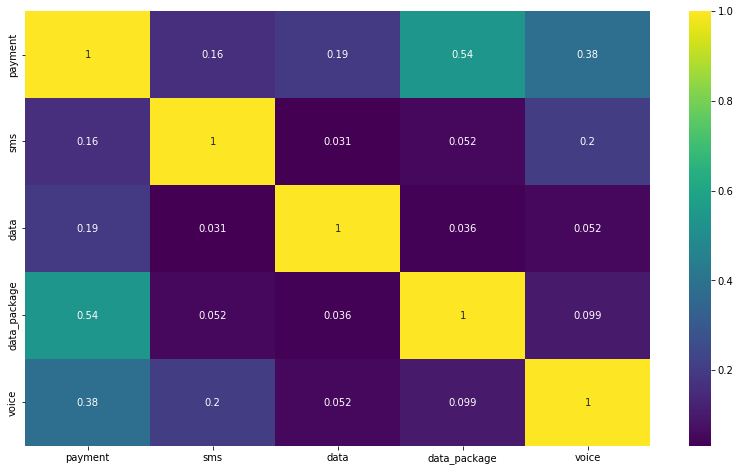

In [60]:
plt.figure(figsize=(14,8))
sns.heatmap(S_D_Ptype.corr(),annot=True,cmap='viridis');

In [61]:
All_observation = S_D_Ptype['serial_number']
A_NotPaid = S_D_Ptype[S_D_Ptype['payment'] == 0]['serial_number']
A_Paid = complements(A_NotPaid, All_observation)
A_lessPaid = S_D_Ptype[S_D_Ptype['payment'] < S_D_Ptype['payment'].mean()]['serial_number']
A_lessPaid_without_NotPayment = intersect(A_lessPaid, A_Paid)
A_upper_mean = S_D_Ptype[S_D_Ptype['payment'] >= S_D_Ptype['payment'].mean()]['serial_number']
A_upper_95 = S_D_Ptype[S_D_Ptype['payment'] >= np.quantile(S_D_Ptype['payment'],.95)]['serial_number']

Pnot_payment = probability(A_NotPaid, All_observation)
Pless_than_mean = probability(A_lessPaid_without_NotPayment, All_observation)
Pmore_than_mean = probability(A_upper_mean, All_observation)
Pmore_than_95 = probability(A_upper_95, All_observation)
Payment_probability = [Pnot_payment, Pless_than_mean, Pmore_than_mean, Pmore_than_95]
print('''probability the observation that has no payment in next month: {0}
probability the observation that payment less than mean exclude no payment of population: {1}
probability the observation that payment more than mean of population: {2}
probability the observation that payment more than 95% of population: {3}'''
.format(Payment_probability[0],Payment_probability[1],Payment_probability[2],Payment_probability[3]))

probability the observation that has no payment in next month: 0.22991
probability the observation that payment less than mean exclude no payment of population: 0.421275
probability the observation that payment more than mean of population: 0.348815
probability the observation that payment more than 95% of population: 0.050075


In [62]:
All_observation = S_D_Ptype['serial_number']
# less than first quantile
A_V_l_1q = S_D_Ptype[S_D_Ptype['voice'] <= np.quantile(S_D_Ptype['voice'],.25)]['serial_number']
# between first quantile and median
A_V_l_median = S_D_Ptype[S_D_Ptype['voice'] < np.quantile(S_D_Ptype['voice'],.5)]['serial_number']
A_V_l_median_g_1q = intersect(A_V_l_median, complements(A_V_l_1q, All_observation))
# between median and third quantile
A_V_g_median = complements(A_V_l_median, All_observation)
A_V_l_3q = S_D_Ptype[S_D_Ptype['voice'] < np.quantile(S_D_Ptype['voice'],.75)]['serial_number']
A_V_g_median_1_3q = intersect(A_V_l_3q, A_V_g_median)
# between third quantile and 0.95 of usage
A_V_g_3q = complements(A_V_l_3q, All_observation)
A_V_l_95 = S_D_Ptype[S_D_Ptype['voice'] < np.quantile(S_D_Ptype['voice'],.95)]['serial_number']
A_V_l_95_g_3q = intersect(A_V_g_3q, A_V_l_95)

A_Voice_observation = [A_V_l_1q, A_V_l_median_g_1q, A_V_g_median_1_3q, A_V_l_95_g_3q]

# addition the probability of different of voice usage
P_l_1q = probability(A_V_l_1q,All_observation)
P_l_median_g_1q = probability(A_V_l_median_g_1q,All_observation)
P_l_3q_g_median = probability(A_V_g_median_1_3q,All_observation)
P_l_95_g_3q = probability(A_V_l_95_g_3q,All_observation)

Probability_Voice = [P_l_1q, P_l_median_g_1q, P_l_3q_g_median, P_l_95_g_3q]
print('''probability the observation that has usage of voice lesser than 1q in next month: {0}
probability the observation that has usage of voice lesser than median greater than 1q: {1}
probability the observation that has usage of voice lesser than 3q greater than median: {2}
probability the observation that has usage of voice lesser than 95% greater than 3q: {3}'''
.format(Probability_Voice[0],Probability_Voice[1],Probability_Voice[2],Probability_Voice[3]))

probability the observation that has usage of voice lesser than 1q in next month: 0.25
probability the observation that has usage of voice lesser than median greater than 1q: 0.25
probability the observation that has usage of voice lesser than 3q greater than median: 0.25
probability the observation that has usage of voice lesser than 95% greater than 3q: 0.2


In [63]:
All_observation = S_D_Ptype['serial_number']
# less than first quantile
A_S_l_1q = S_D_Ptype[S_D_Ptype['sms'] <= np.quantile(S_D_Ptype['sms'],.25)]['serial_number']
# between first quantile and median
A_S_l_median = S_D_Ptype[S_D_Ptype['sms'] < np.quantile(S_D_Ptype['sms'],.5)]['serial_number']
A_S_l_median_g_1q = intersect(A_S_l_median, complements(A_S_l_1q, All_observation))
# between median and third quantile
A_S_g_median = complements(A_S_l_median, All_observation)
A_S_l_3q = S_D_Ptype[S_D_Ptype['sms'] < np.quantile(S_D_Ptype['sms'],.75)]['serial_number']
A_S_g_median_1_3q = intersect(A_S_l_3q, A_S_g_median)
# between third quantile and 0.95 of usage
A_S_g_3q = complements(A_S_l_3q, All_observation)
A_S_l_95 = S_D_Ptype[S_D_Ptype['sms'] < np.quantile(S_D_Ptype['sms'],.95)]['serial_number']
A_S_l_95_g_3q = intersect(A_S_g_3q, A_S_l_95)

A_SMS_observation = [A_S_l_1q, A_S_l_median_g_1q, A_S_g_median_1_3q, A_S_l_95_g_3q]

# addition the probability of different of sms usage
P_l_1q = probability(A_S_l_1q,All_observation)
P_l_median_g_1q = probability(A_S_l_median_g_1q,All_observation)
P_l_3q_g_median = probability(A_S_g_median_1_3q,All_observation)
P_l_95_g_3q = probability(A_S_l_95_g_3q,All_observation)

Probability_SMS = [P_l_1q, P_l_median_g_1q, P_l_3q_g_median, P_l_95_g_3q]
print('''probability the observation that has usage of sms lesser than 1q in next month: {0}
probability the observation that has usage of sms lesser than median greater than 1q: {1}
probability the observation that has usage of sms lesser than 3q greater than median: {2}
probability the observation that has usage of sms lesser than 95% greater than 3q: {3}'''
.format(Probability_SMS[0],Probability_SMS[1],Probability_SMS[2],Probability_SMS[3]))

probability the observation that has usage of sms lesser than 1q in next month: 0.25288
probability the observation that has usage of sms lesser than median greater than 1q: 0.24693
probability the observation that has usage of sms lesser than 3q greater than median: 0.250165
probability the observation that has usage of sms lesser than 95% greater than 3q: 0.20001


In [64]:
All_observation = S_D_Ptype['serial_number']
# less than first quantile
A_DP_l_1q = S_D_Ptype[S_D_Ptype['data_package'] <= np.quantile(S_D_Ptype['data_package'],.25)]['serial_number']
# between first quantile and median
A_DP_l_median = S_D_Ptype[S_D_Ptype['data_package'] < np.quantile(S_D_Ptype['data_package'],.5)]['serial_number']
A_DP_l_median_g_1q = intersect(A_DP_l_median, complements(A_DP_l_1q, All_observation))
# between median and third quantile
A_DP_g_median = complements(A_DP_l_median, All_observation)
A_DP_l_3q = S_D_Ptype[S_D_Ptype['data_package'] < np.quantile(S_D_Ptype['data_package'],.75)]['serial_number']
A_DP_g_median_1_3q = intersect(A_DP_l_3q, A_DP_g_median)
# between third quantile and 0.95 of usage
A_DP_g_3q = complements(A_DP_l_3q, All_observation)
A_DP_l_95 = S_D_Ptype[S_D_Ptype['data_package'] < np.quantile(S_D_Ptype['data_package'],.95)]['serial_number']
A_DP_l_95_g_3q = intersect(A_DP_g_3q, A_DP_l_95)

A_data_package_observation = [A_DP_l_1q, A_DP_l_median_g_1q, A_DP_g_median_1_3q, A_DP_l_95_g_3q]

# addition the probability of different of data_package usage
P_l_1q = probability(A_DP_l_1q,All_observation)
P_l_median_g_1q = probability(A_DP_l_median_g_1q,All_observation)
P_l_3q_g_median = probability(A_DP_g_median_1_3q,All_observation)
P_l_95_g_3q = probability(A_DP_l_95_g_3q,All_observation)

Probability_data_package = [P_l_1q, P_l_median_g_1q, P_l_3q_g_median, P_l_95_g_3q]
print('''probability the observation that has usage of data_package lesser than 1q in next month: {0}
probability the observation that has usage of data_package lesser than median greater than 1q: {1}
probability the observation that has usage of data_package lesser than 3q greater than median: {2}
probability the observation that has usage of data_package lesser than 95% greater than 3q: {3}'''
.format(Probability_data_package[0],Probability_data_package[1],Probability_data_package[2],Probability_data_package[3]))

probability the observation that has usage of data_package lesser than 1q in next month: 0.507475
probability the observation that has usage of data_package lesser than median greater than 1q: 0.0
probability the observation that has usage of data_package lesser than 3q greater than median: 0.73711
probability the observation that has usage of data_package lesser than 95% greater than 3q: 0.21288


In [65]:
All_observation = S_D_Ptype['serial_number']
# less than first quantile
A_D_l_1q = S_D_Ptype[S_D_Ptype['data'] <= np.quantile(S_D_Ptype['data'],.25)]['serial_number']
# between first quantile and median
A_D_l_median = S_D_Ptype[S_D_Ptype['data'] < np.quantile(S_D_Ptype['data'],.5)]['serial_number']
A_D_l_median_g_1q = intersect(A_D_l_median, complements(A_D_l_1q, All_observation))
# between median and third quantile
A_D_g_median = complements(A_D_l_median, All_observation)
A_D_l_3q = S_D_Ptype[S_D_Ptype['data'] < np.quantile(S_D_Ptype['data'],.75)]['serial_number']
A_D_g_median_1_3q = intersect(A_D_l_3q, A_D_g_median)
# between third quantile and 0.95 of usage
A_D_g_3q = complements(A_D_l_3q, All_observation)
A_D_l_95 = S_D_Ptype[S_D_Ptype['data'] < np.quantile(S_D_Ptype['data'],.95)]['serial_number']
A_D_l_95_g_3q = intersect(A_D_g_3q, A_D_l_95)

A_data_observation = [A_D_l_1q, A_D_l_median_g_1q, A_D_g_median_1_3q, A_D_l_95_g_3q]

# addition the probability of different of data usage
P_l_1q = probability(A_D_l_1q,All_observation)
P_l_median_g_1q = probability(A_D_l_median_g_1q,All_observation)
P_l_3q_g_median = probability(A_D_g_median_1_3q,All_observation)
P_l_95_g_3q = probability(A_D_l_95_g_3q,All_observation)

Probability_data = [P_l_1q, P_l_median_g_1q, P_l_3q_g_median, P_l_95_g_3q]
print('''probability the observation that has usage of data lesser than 1q in next month: {0}
probability the observation that has usage of data lesser than median greater than 1q: {1}
probability the observation that has usage of data lesser than 3q greater than median: {2}
probability the observation that has usage of data lesser than 95% greater than 3q: {3}'''
.format(Probability_data[0],Probability_data[1],Probability_data[2],Probability_data[3]))

probability the observation that has usage of data lesser than 1q in next month: 0.657415
probability the observation that has usage of data lesser than median greater than 1q: 0.0
probability the observation that has usage of data lesser than 3q greater than median: 0.75
probability the observation that has usage of data lesser than 95% greater than 3q: 0.2


Again the output of probabilities are sami-equal to previous information, so the payment_type distribution are not affect our data

### look data as sample data of all company subscribers

- take the estimation with confidence interval equal with 99%, because our sample has huge we can take it as normal distribution

In [66]:
def Mu_estimation(column, CI):
    z_critical= scipy.stats.norm.ppf(q= CI)
    sample_size = data[column].count()
    sample_mean = data[column].mean()
    sample_std = data[column].std()
    margin_error = z_critical*(sample_std/(math.sqrt(sample_size)))
    return (sample_mean-margin_error, sample_mean+margin_error)

def Pro_estimation(column, CI, great_prcentage):
    z_critical= scipy.stats.norm.ppf(q= CI)
    sample_size = data[column].count()
    P_success = data[data[column] < np.quantile(data[column],great_prcentage)][column].count() / sample_size
    margin_error = z_critical*math.sqrt(P_success*(1-P_success)/sample_size)
    return (P_success-margin_error, P_success+margin_error)


In [67]:
columns = ['payment','voice','sms','data_package','data']

CI = 0.995
great_prcentage = 0.95
Mu_estimations = []
Pro_estimations = []

for i in columns:
    Mu_estimations.append(Mu_estimation(i, CI))
    Pro_estimations.append(Pro_estimation(i, CI, great_prcentage))

Mu_Prop_table = PrettyTable(['Mu_estimation','Pro_estimation'])
for i in range(len(Mu_estimations)):
    Mu_Prop_table.add_row([Mu_estimations[i],Pro_estimations[i]])
Mu_Prop_table.add_column('features',['payment','voice','sms','data-package','data'])

In [68]:
Mu_Prop_table

Mu_estimation,Pro_estimation,features
"(0.997720376445152, 1.0022796235548475)","(0.948420773083715, 0.9491324729249205)",payment
"(0.9972952928544804, 1.0027047071455206)","(0.9496445539451, 0.9503481809961021)",voice
"(0.994430258054649, 1.0055697419453502)","(0.9496461300037775, 0.9503497465844724)",sms
"(0.9970011703818481, 1.0029988296181542)","(0.9496481000772595, 0.9503517035698)",data-package
"(0.9930006540581789, 1.0069993459418192)","(0.9496481000772595, 0.9503517035698)",data


#### Confidence Interval for Mu1 and Mu2

In [69]:
def Mu1_Mu2_estimation(column1, column2, CI):
    z_critical= scipy.stats.norm.ppf(q= CI)
    n1, n2= S_Data[column1].count(), S_Data[column2].count()
    var1, var2 = S_Data[column1].var(), S_Data[column2].var()
    C1_mean,C2_mean = S_Data[column1].mean(), S_Data[column2].mean()
    diff_mean = C2_mean - C1_mean
    margin_error = z_critical * (math.sqrt((var1/n1)+(var2/n2)))
    return (diff_mean-margin_error, diff_mean+margin_error)

In [70]:
print('Confidence Interval of voice and sms: {0}'.format(Mu1_Mu2_estimation('voice','sms',0.995)))

Confidence Interval of voice and sms: (0.06016453989484975, 0.08309280485239563)


### hypothesis test
- We want to do hypothesis test for understanding the deffirence between Mu of two of our features are lesser than specific number or not
- because the both voice service and selling data package are important for company, before any more investigation, the company wants to now the deffirence between mean of these two service are equal or enough near to plan for next invetigation

In [71]:
def Mu1_Mu2_Hypothesis_test(column1, column2, D):
    n1, n2= S_D_Ptype[column1].count(), S_D_Ptype[column2].count()
    var1, var2 = S_D_Ptype[column1].var(), S_D_Ptype[column2].var()
    C1_mean,C2_mean = S_D_Ptype[column1].mean(), S_D_Ptype[column2].mean()
    return (C1_mean - C2_mean - D) / math.sqrt((var1/n1)+(var2/n2))


In [72]:
# Now, we will find the mean of population usage using the sample D = 0.5
Mu1_Mu2_Hypothesis_test('voice','data_package', 0.5)

-65.05729807007307

As the value shows it is alot different exist between of the mean of selling data_package and usage of people of voice, so we can't reject the hypothesis testing